# AppSec skills analysis (HeadHunter / out_hh)

This notebook builds analytical charts from `out_hh/skills_top.csv` to summarize common skills requested for AppSec roles.

## Categories
Each skill is mapped into exactly one category (first match wins):
- Base knowledge
- Web technologies
- Security testing
- Development
- Languages
- Cryptography
- Code security instruments

In [66]:
from __future__ import annotations

import re
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 120)

In [67]:
# ---- Load data ----
out_dir = Path('out_hh')
skills_path = out_dir / 'skills_top.csv'

if not skills_path.exists():
    raise FileNotFoundError(f'Expected file not found: {skills_path.resolve()}')

df = pd.read_csv(skills_path)
df['count'] = pd.to_numeric(df['count'], errors='coerce').fillna(0).astype(int)
df = df.sort_values('count', ascending=False).reset_index(drop=True)
df.head(20)

,skill,count
0,Python,52
1,CI/CD,52
2,OWASP,51
3,SAST,46
4,Kubernetes,43
5,DAST,43
6,SCA,39
7,DevSecOps,38
8,Java,28
9,Secure SDLC,27


## Categorization rules
The mapping is heuristic (keyword/regex based). If some items look misclassified, add a fixed mapping to `OVERRIDES`.

In [68]:
CATEGORIES = [
    'base knowledge',
    'web technologies',
    'security testing',
    'development',
    'languages',
    'cryptography',
    'code security instruments',
]

# Exact-match overrides (optional).
OVERRIDES: dict[str, str] = {
    # 'WAF': 'web technologies',
}

RULES: list[tuple[str, list[str]]] = [
    ('code security instruments', [
        r'\bsemgrep\b', r'\bsonarqube\b', r'\bcodeql\b',
        r'\bsnyk\b', r'\bcheckmarx\b', r'\bveracode\b', r'\bfortify\b',
    ]),
    ('cryptography', [r'\btls\b', r'\bpki\b', r'\bcrypto\b', r'крипт', r'шифр']),
    ('languages', [
        r'\bpython\b', r'\bjava\b', r'\bjavascript\b', r'\btypescript\b',
        r'\bgo(lang)?\b', r'\brust\b', r'\bc\+\+\b', r'\bc#\b',
        r'\bphp\b', r'\bruby\b', r'\bscala\b', r'\bkotlin\b', r'\bswift\b',
        r'\bbash\b', r'\bshell\b', r'\bsql\b',
    ]),
    ('web technologies', [
        r'http', r'\boauth\s*2\b', r'\boidc\b', r'\bjwt\b',
        r'\bcors\b', r'\bcsrf\b', r'\bxss\b', r'\bssrf\b',
        r'\bsessions?\b', r'\bcookies?\b', r'web\s*security', r'\bapi\b',
        r'graphql', r'rest', r'waf',
    ]),
    ('security testing', [
        r'\bsast\b', r'\bdast\b', r'\bsca\b', r'pentest',
        r'\bburp\b', r'owasp\s*zap', r'\bnmap\b', r'fuzz', r'vuln',
    ]),
    ('development', [
        r'ci/?cd', r'devsecops', r'kubernetes', r'\bk8s\b', r'docker',
        r'git', r'linux', r'agile', r'secure\s*sdlc', r'\bsdlc\b', r'\bssdlc\b',
        r'pipeline',
    ]),
    ('base knowledge', [
        r'owasp', r'\bcwe\b', r'owasp\s*top\s*10', r'\bcvss\b',
        r'threat\s*model', r'информационн', r'information\s*security',
        r'logging', r'\bsiem\b',
    ]),
]

def categorize_skill(skill: str) -> str:
    skill = str(skill).strip()
    if skill in OVERRIDES:
        return OVERRIDES[skill]
    s = skill.lower()
    for category, patterns in RULES:
        for pat in patterns:
            if re.search(pat, s, flags=re.IGNORECASE):
                return category
    return 'base knowledge'

df['category'] = df['skill'].apply(categorize_skill)
df['category'] = pd.Categorical(df['category'], categories=CATEGORIES, ordered=True)
df.head(20)

,skill,count,category
0,Python,52,languages
1,CI/CD,52,development
2,OWASP,51,base knowledge
3,SAST,46,security testing
4,Kubernetes,43,development
5,DAST,43,security testing
6,SCA,39,security testing
7,DevSecOps,38,development
8,Java,28,languages
9,Secure SDLC,27,development


In [69]:
# Category distribution (sum of mentions)
cat_counts = df.groupby('category', observed=True)['count'].sum().sort_values(ascending=False)
cat_counts

category
base knowledge               379
development                  242
security testing             199
languages                    124
web technologies              56
code security instruments     26
cryptography                  22
Name: count, dtype: int64

## Chart 1 — Top skills (colored by category)

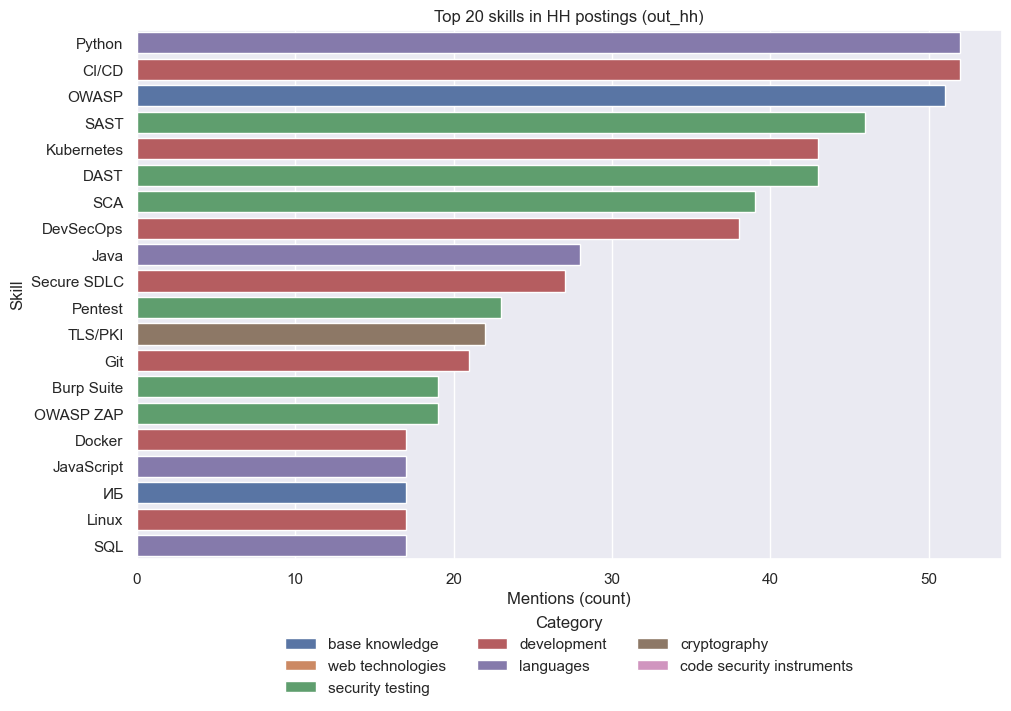

In [81]:
top_n = 20
top = df.head(top_n).copy()

# Wider and less tall; keep the plot compact and avoid a large empty right margin.
fig, ax = plt.subplots(figsize=(10, 7), constrained_layout=True)

sns.barplot(data=top, y='skill', x='count', hue='category', dodge=False, ax=ax)
ax.set_title(f'Top {top_n} skills in HH postings (out_hh)')
ax.set_xlabel('Mentions (count)')
ax.set_ylabel('Skill')

# Put legend below to reduce empty side space
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Category', loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=3, frameon=False)

plt.show()

## Chart 2 — Category distribution

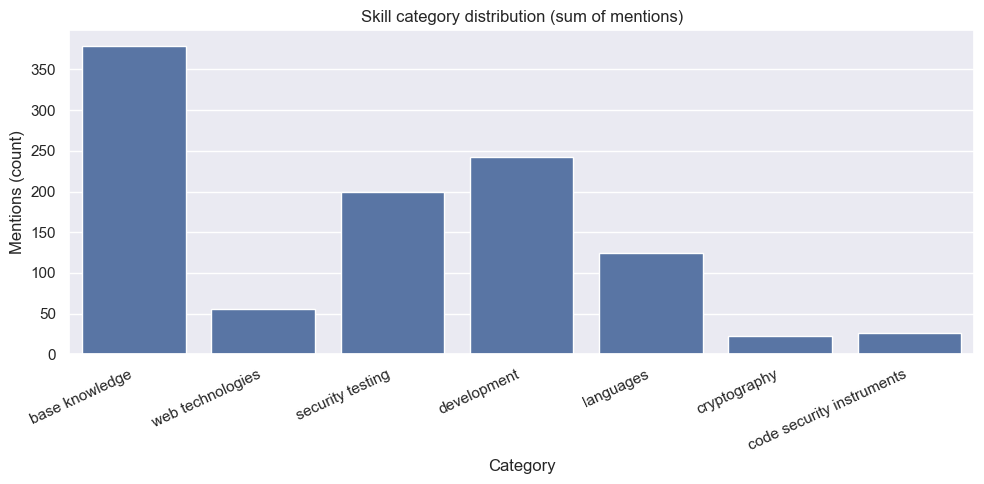

In [71]:
cat_df = (df.groupby('category', observed=True)['count'].sum().reset_index().sort_values('count', ascending=False))

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=cat_df, x='category', y='count')
ax.set_title('Skill category distribution (sum of mentions)')
ax.set_xlabel('Category')
ax.set_ylabel('Mentions (count)')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

## Chart 3 — Top skills within each category

In [72]:
top_k = 10
rows = []
for cat in CATEGORIES:
    tmp = df[df['category'] == cat].nlargest(top_k, 'count')
    if tmp.empty:
        continue
    rows.append(tmp)
per_cat = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=df.columns)
per_cat.head()

,skill,count,category
0,OWASP,51,base knowledge
1,ИБ,17,base knowledge
2,Logging/SIEM,16,base knowledge
3,CWE,12,base knowledge
4,Bug bounty,11,base knowledge


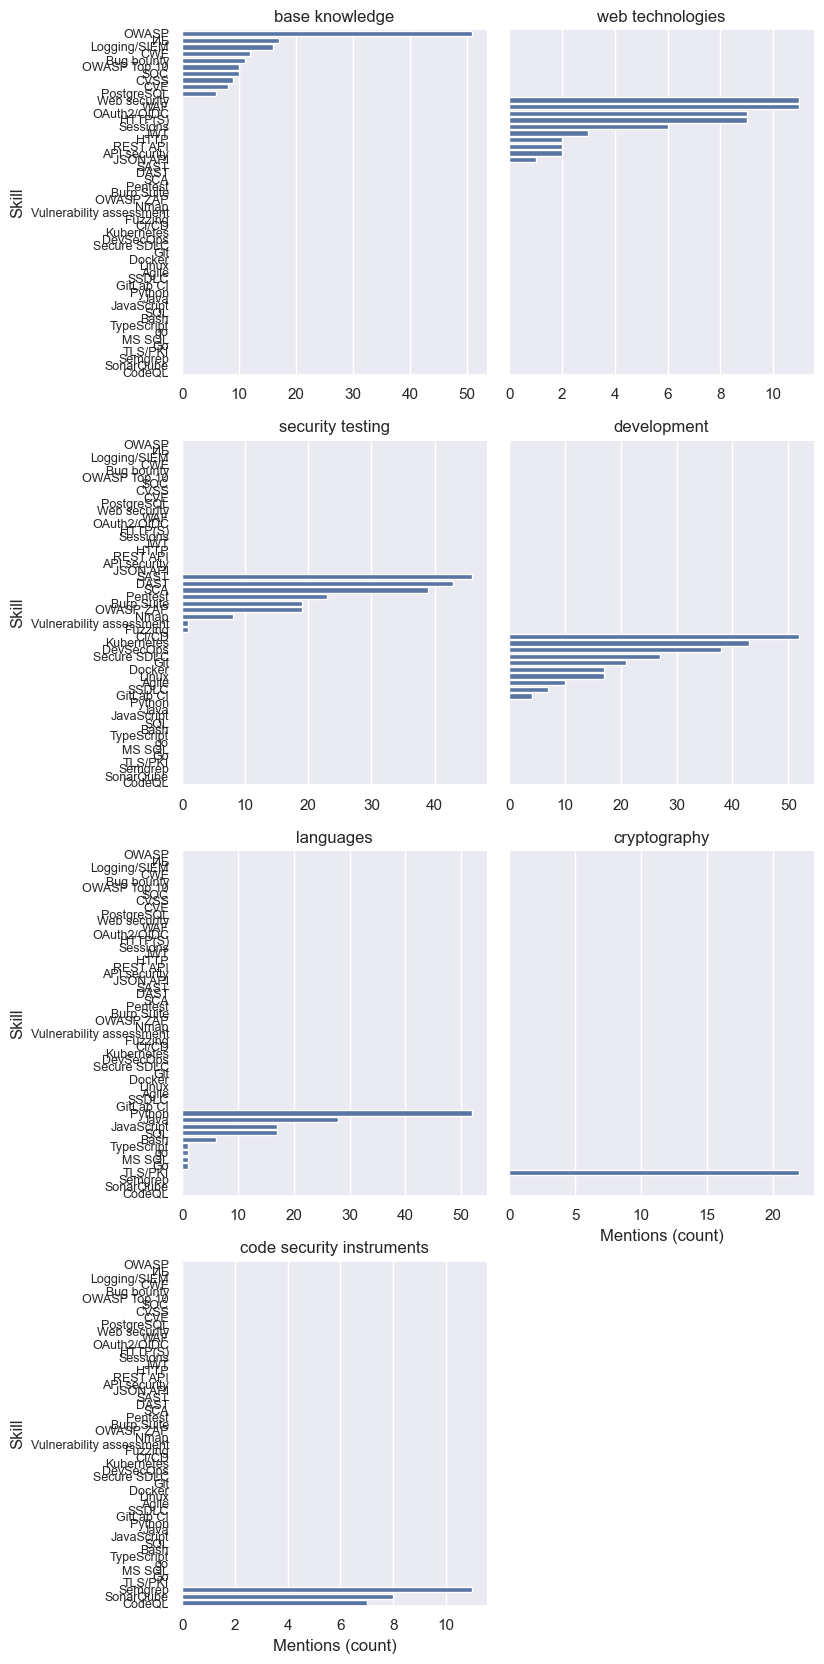

In [73]:
g = sns.FacetGrid(per_cat, col='category', col_wrap=2, sharex=False, height=4.2)
g.map_dataframe(sns.barplot, y='skill', x='count', color=sns.color_palette()[0])
g.set_titles('{col_name}')
g.set_axis_labels('Mentions (count)', 'Skill')
for ax in g.axes.flatten():
    ax.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()

## Grade analysis (junior / middle / senior)
This section uses `out_hh_grade_test2/skills_by_grade.csv` (if present) to show which skills are most commonly requested per grade.

In [74]:
df_grade = pd.read_csv(out_dir / 'skills_by_grade.csv')
df_grade.columns = [c.strip().lower() for c in df_grade.columns]
df_grade = df_grade.fillna(0)

# Convert to long format: one row per (skill, grade)
grade_cols = [c for c in df_grade.columns if c not in ('skill', 'total')]
long = df_grade.melt(id_vars=['skill'], value_vars=grade_cols, var_name='grade', value_name='count')
long['count'] = pd.to_numeric(long['count'], errors='coerce').fillna(0).astype(int)

# Attach categories using the same categorizer as above
long['category'] = long['skill'].apply(categorize_skill)
long['category'] = pd.Categorical(long['category'], categories=CATEGORIES, ordered=True)

long.head()

,skill,grade,count,category
0,Python,junior,17,languages
1,CI/CD,junior,14,development
2,OWASP,junior,18,base knowledge
3,SAST,junior,11,security testing
4,Kubernetes,junior,9,development


In [75]:
# Table: top skills per grade
top_k = 15
tables = {}
for gname in ['junior', 'middle', 'senior', 'unknown']:
    if gname not in set(long['grade']):
        continue
    t = (long[long['grade'] == gname]
         .sort_values('count', ascending=False)
         .head(top_k)
         .loc[:, ['skill', 'count', 'category']])
    tables[gname] = t

tables.get('junior', pd.DataFrame()).head(10)

,skill,count,category
2,OWASP,18,base knowledge
0,Python,17,languages
1,CI/CD,14,development
5,DAST,13,security testing
6,SCA,12,security testing
3,SAST,11,security testing
7,DevSecOps,10,development
4,Kubernetes,9,development
9,Secure SDLC,9,development
10,Pentest,9,security testing


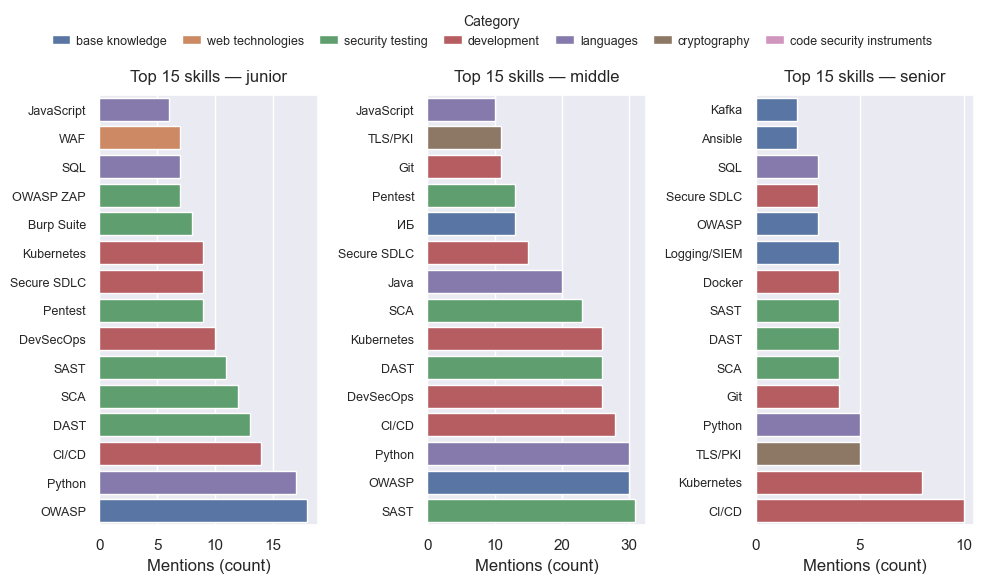

In [82]:
# Plot: top skills per grade (3 panels)
grades_for_plot = [g for g in ['junior', 'middle', 'senior'] if g in set(long['grade'])]
n_panels = len(grades_for_plot)

# Use tight_layout with a reserved top band for the figure-level legend (prevents overlap)
fig, axes = plt.subplots(1, n_panels, figsize=(10, 6), constrained_layout=False)
if n_panels == 1:
    axes = [axes]

for ax, gname in zip(axes, grades_for_plot):
    t = tables[gname].sort_values('count', ascending=True)  # ascending for nicer horizontal bars
    sns.barplot(data=t, y='skill', x='count', hue='category', dodge=False, ax=ax)
    ax.set_title(f'Top {top_k} skills — {gname}', pad=10)
    ax.set_xlabel('Mentions (count)')
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=9)
    # Remove per-axes legends; we add one shared legend above
    if ax.get_legend() is not None:
        ax.get_legend().remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='Category',
    loc='upper center',
    ncol=min(len(labels), 7),
    frameon=False,
    bbox_to_anchor=(0.5, 0.98),
    fontsize=9,
    title_fontsize=10,
    handlelength=1.5,
    columnspacing=1.2,
    handletextpad=0.5,
 )

# Reserve space for the legend band
fig.tight_layout(rect=(0, 0, 1, 0.90))
plt.show()

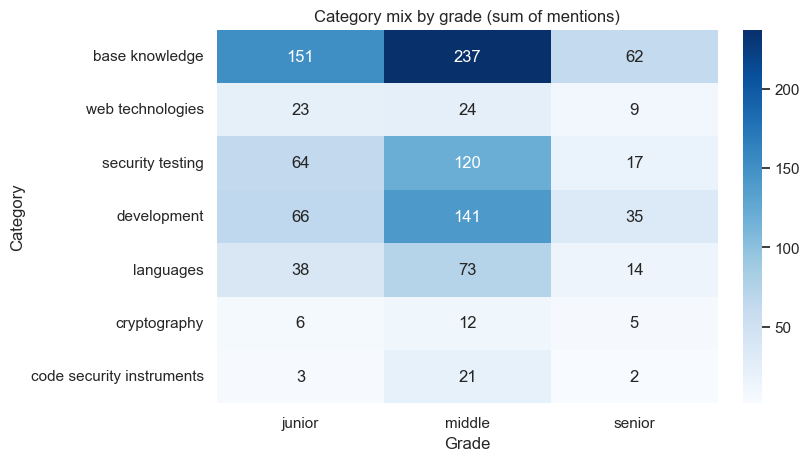

In [77]:
# Plot: category mix by grade (heatmap of total mentions)
mix = (long[long['grade'].isin(grades_for_plot)]
       .groupby(['category', 'grade'], observed=True)['count']
       .sum()
       .reset_index())

pivot = mix.pivot(index='category', columns='grade', values='count').fillna(0).astype(int)
plt.figure(figsize=(8, 4.5), constrained_layout=True)
ax = sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
ax.set_title('Category mix by grade (sum of mentions)')
ax.set_xlabel('Grade')
ax.set_ylabel('Category')
plt.show()

## Export categorized results (optional)
Writes `out_hh/skills_top_categorized.csv` for manual review/tuning.

In [78]:
out_path = out_dir / 'skills_top_categorized.csv'
df.to_csv(out_path, index=False)
out_path

PosixPath('out_hh/skills_top_categorized.csv')